In [25]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

In [26]:
df = pd.read_csv('data/train_engineered_feature_importance.csv')
df

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,multiple_deliveries,Festival,Time_taken(min),Delivery_Distance (m),Ordered_time (mins)
0,37.0,4.9,Sunny,High,2.0,0.0,No,24,3025.149286,690
1,34.0,4.5,Stormy,Jam,2.0,1.0,No,33,20183.529729,1185
2,23.0,4.4,Sandstorms,Low,0.0,1.0,No,26,1552.757802,510
3,38.0,4.7,Sunny,Medium,0.0,1.0,No,21,7790.401360,1080
4,32.0,4.6,Cloudy,High,1.0,1.0,No,30,6210.137966,810
...,...,...,...,...,...,...,...,...,...,...
41363,30.0,4.8,Windy,High,1.0,0.0,No,32,1489.845884,695
41364,21.0,4.6,Windy,Jam,0.0,1.0,No,36,11007.734764,1195
41365,30.0,4.9,Cloudy,Low,1.0,0.0,No,16,4657.195394,1430
41366,20.0,4.7,Cloudy,High,0.0,1.0,No,26,6232.393050,815


# Train/Valid/Test Split

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score

In [28]:
X = df.drop('Time_taken(min)', axis=1)
Y = df['Time_taken(min)']

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size= 0.2)

# Linear Classifiers
- Lasso
- Ridge
- Polynomial

In [29]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Polynomial

In [30]:
linreg = make_pipeline(FunctionTransformer(pd.get_dummies, kw_args={'drop_first':True}), LinearRegression()).fit(xtrain, ytrain)

In [31]:
mean_squared_error(linreg.predict(xtest), ytest)

38.257840580791175

## Lasso

In [33]:
alpha = [0.1, 0.3, 0.5, 0.75, 1, 3, 5, 10]
ridgecv = make_pipeline(FunctionTransformer(pd.get_dummies, kw_args={'drop_first':True}), RidgeCV(alphas=alpha, cv=5)).fit(xtrain,ytrain)

In [34]:
# get cross validation results for ridge regression
mean_squared_error(ridgecv.predict(xtest), ytest)

38.257846540777656

## Lasso Regression

In [36]:
alpha = [0.1, 0.3, 0.5, 0.75, 1, 3, 5, 10]
lassocv = make_pipeline(FunctionTransformer(pd.get_dummies, kw_args={'drop_first':True}), LassoCV(alphas=alpha, cv=5)).fit(xtrain,ytrain)

In [37]:
# get cross validation results for lasso regression
mean_squared_error(lassocv.predict(xtest), ytest)

39.65652632283858

# Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [40]:
# Grid Search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 320, stop = 380, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

rf_model = make_pipeline(FunctionTransformer(pd.get_dummies, kw_args={'drop_first':True}), RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)).fit(xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [42]:
# hyperparameter tuning
rf_model['randomizedsearchcv'].best_params_

{'n_estimators': 354,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 45,
 'bootstrap': True}

In [43]:
mean_squared_error(ytest, rf_model.predict(xtest))

14.857359926798747

### Feature Importance

In [44]:
start_time = time.time()
rf_model_tree = rf_model['randomizedsearchcv'].best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model['randomizedsearchcv'].best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.042 seconds


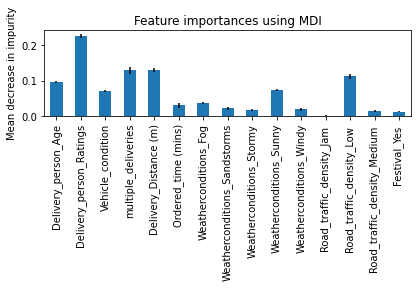

In [45]:
forest_importance = pd.Series(rf_model_tree, index=pd.get_dummies(xtrain, drop_first=True).columns.values)

fig, ax = plt.subplots()
forest_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

From this we can see that the ordered year, type of order, type of vehicle, city are not important features. This was removed and another dataset was created

# KNN Regression

In [47]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Normalizer

In [48]:
kfold = KFold(n_splits=5, shuffle=True)
knn_hyper = {'model__n_neighbors':[21,22,23,24],
              'model__weights':['uniform','distance']}

knn = Pipeline([('onehot', FunctionTransformer(pd.get_dummies, kw_args={'drop_first':True})),
                           ('normalize', Normalizer()),
                           ('model', KNeighborsRegressor())
                           ])

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_hyper, cv=kfold, scoring='neg_mean_squared_error')
knn_grid.fit(xtrain,ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('onehot',
                                        FunctionTransformer(func=<function get_dummies at 0x7fa1b9212280>,
                                                            kw_args={'drop_first': True})),
                                       ('normalize', Normalizer()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [21, 22, 23, 24],
                         'model__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [49]:
knn_grid.best_estimator_

Pipeline(steps=[('onehot',
                 FunctionTransformer(func=<function get_dummies at 0x7fa1b9212280>,
                                     kw_args={'drop_first': True})),
                ('normalize', Normalizer()),
                ('model',
                 KNeighborsRegressor(n_neighbors=21, weights='distance'))])

In [50]:
mean_squared_error(ytest, knn_grid.predict(xtest))

58.49775470132297